# Project: Investigate Motion Picture Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#caveats">Caveats</a></li>
<li><a href="#references">References</a></li>
</ul>

<a id='intro'></a>
## Introduction

This data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.

In this notebook I will explore the following questions:

<ul>
<li><a href="genre_analysis">What genres are most popular?</a></li>
<li><a href="genre_revenue">What genres earn the highest revenue?</a></li>
<li><a href="director_revenue">What directors earn the highest revenue?</a></li>
<li><a href="cast_revenue">What cast members earn the highest revenue?</a></li>
</ul>

## Preparation

In [59]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot
%matplotlib inline
pyplot.style.use = 'default'

<a id='wrangling'></a>
## Data Wrangling

### Load data and inspect

In [60]:
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [61]:
df.shape

(10866, 21)

The dataset has **10,866 movie records** and **21 features**.

What are the datatypes and are there any null values?

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

The datatypes of each feature seem appropriate except for the following:
* Release Date should be a Date not a String

The following columns contain lists of items delimited by '|':
* Cast
* Genres
* Production Companies

Are there any numeric features with values of 0?

In [63]:
(df == 0.0).sum()

id                         0
imdb_id                    0
popularity                 0
budget                  5696
revenue                 6016
original_title             0
cast                       0
homepage                   0
director                   0
tagline                    0
keywords                   0
overview                   0
runtime                   31
genres                     0
production_companies       0
release_date               0
vote_count                 0
vote_average               0
release_year               0
budget_adj              5696
revenue_adj             6016
dtype: int64

Some features are incomplete (missing data) and some features have 0 values which are invalid

What proportion of data is missing for each feature?

In [64]:
def get_percentage_missing(series):
    """ Calculates percentage of NaN values in DataFrame
    :param series: Pandas DataFrame object
    :return: float
    """
    num = series.isnull().sum()
    den = len(series)
    return round((num/den)*100, 2)

df_with_any_null_values = df[df.columns[df.isnull().any()].tolist()]

for name, values in df_with_any_null_values.iteritems():
    print("{0} - {1}% missing".format(name, get_percentage_missing(df_with_any_null_values[name])))

imdb_id - 0.09% missing
cast - 0.7% missing
homepage - 72.98% missing
director - 0.4% missing
tagline - 25.99% missing
keywords - 13.74% missing
overview - 0.04% missing
genres - 0.21% missing
production_companies - 9.48% missing


The following table shows the features that are missing data and what percentage of the records are missing data for each feature.

Feature | % of records without data
--- | --- 
IMDB ID | 0.09
Cast | 0.70
Homepage | 72.98
Director | 0.40
Tagline | 25.99
Keywords | 13.74
Overview | 0.04
Genres | 0.21
Production Companies | 9.48

### Data Cleaning

#### Clean the Release Date

Convert Release Date to a datetime datatype and store this new Release Date in a column called 'release_date_full_year'.

Before converting the release date to a datetime, first convert the year to four digits from two to avoid ambiguity (e.g. 12/25/1985 instead of 12/25/85).

In [65]:
# Replace the two digit year in the release date feature with the full release year from the release year feature
# e.g. for 10/25/15 take 10/25/ + 2015 = 10/25/2015
df['release_date_full_year'] = df['release_date'].str[:-2] + df['release_year'].map(str)

df['release_date_full_year'].head()

0      6/9/2015
1     5/13/2015
2     3/18/2015
3    12/15/2015
4      4/1/2015
Name: release_date_full_year, dtype: object

Now that the release date contains the full year, convert the datatype from a string to a date

In [66]:
df['release_date_full_year'] = pd.to_datetime(df['release_date_full_year'], format='%m/%d/%Y')

df['release_date_full_year'].head()

0   2015-06-09
1   2015-05-13
2   2015-03-18
3   2015-12-15
4   2015-04-01
Name: release_date_full_year, dtype: datetime64[ns]

Decades are also frequently used for year analysis. Add a release decade column for convenience.

In [67]:
df['release_decade'] = df['release_year']//10*10

#### Deal with packed list columns
Create a function to explode columns that contain lists of values

In [68]:
# Source: https://github.com/cognoma/genes/blob/721204091a96e55de6dcad165d6d8265e67e2a48/2.process.py#L61-L95

def tidy_split(df, column, sep='|', keep=False):
    """
    Split the values of a column and expand so the new DataFrame has one split
    value per row. Filters rows where the column is missing.

    Params
    ------
    df : pandas.DataFrame
        dataframe with the column to split and expand
    column : str
        the column to split and expand
    sep : str
        the string used to split the column's values
    keep : bool
        whether to retain the presplit value as it's own row

    Returns
    -------
    pandas.DataFrame
        Returns a dataframe with the same columns as `df`.
    """
    indexes = list()
    new_values = list()
    df = df.dropna(subset=[column])
    for i, presplit in enumerate(df[column].astype(str)):
        values = presplit.split(sep)
        if keep and len(values) > 1:
            indexes.append(i)
            new_values.append(presplit)
        for value in values:
            indexes.append(i)
            new_values.append(value.strip())
    new_df = df.iloc[indexes, :].copy()
    new_df[column] = new_values
    return new_df

#### Convert adjusted budget and revenue columns
The adjusted budget and revenue features are floats. This is likely because they were calculated based on the budget and revenue features. Budget and revenue numbers are typically reported in whole dollars so convert the adjusted features to integers.

In [69]:
df[['budget_adj', 'revenue_adj']] = df[['budget_adj', 'revenue_adj']].apply(lambda x: x.astype(int))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 23 columns):
id                        10866 non-null int64
imdb_id                   10856 non-null object
popularity                10866 non-null float64
budget                    10866 non-null int64
revenue                   10866 non-null int64
original_title            10866 non-null object
cast                      10790 non-null object
homepage                  2936 non-null object
director                  10822 non-null object
tagline                   8042 non-null object
keywords                  9373 non-null object
overview                  10862 non-null object
runtime                   10866 non-null int64
genres                    10843 non-null object
production_companies      9836 non-null object
release_date              10866 non-null object
vote_count                10866 non-null int64
vote_average              10866 non-null float64
release_year              10866 no

Preview the final dataframe

In [70]:
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,release_date_full_year,release_decade
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,137999939,1392445892,2015-06-09,2010
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,137999939,348161292,2015-05-13,2010
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,101199955,271619025,2015-03-18,2010
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,183999919,1902723129,2015-12-15,2010
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,174799923,1385748801,2015-04-01,2010


## General Analysis

Plot a scatter matrix to look for any obvious relationships

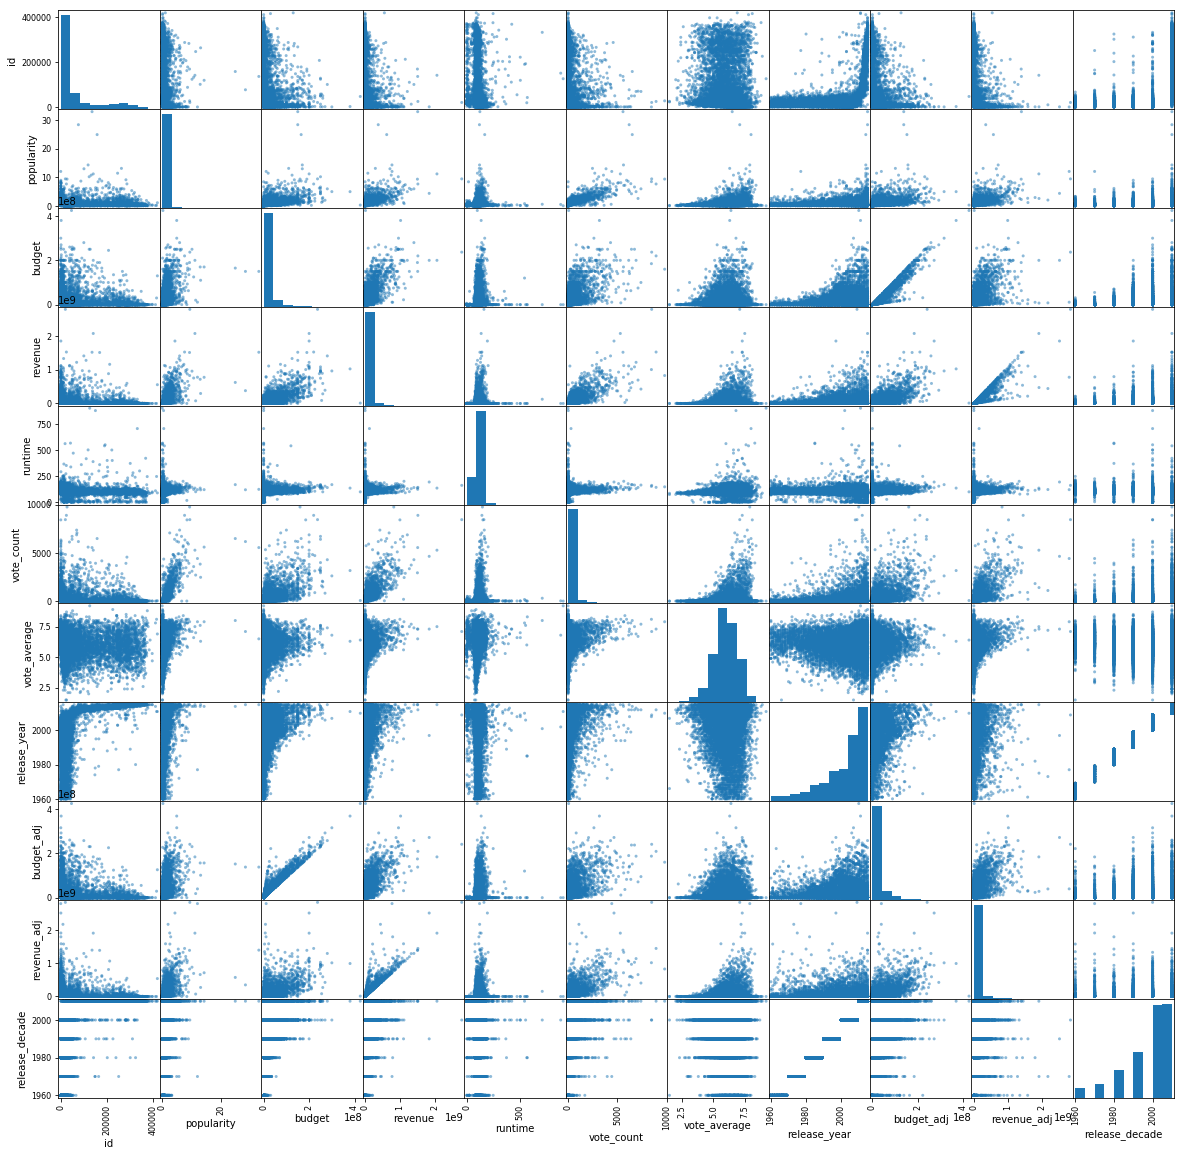

In [71]:
pd.plotting.scatter_matrix(df, figsize=(20,20));

Plot histograms to review data distributions

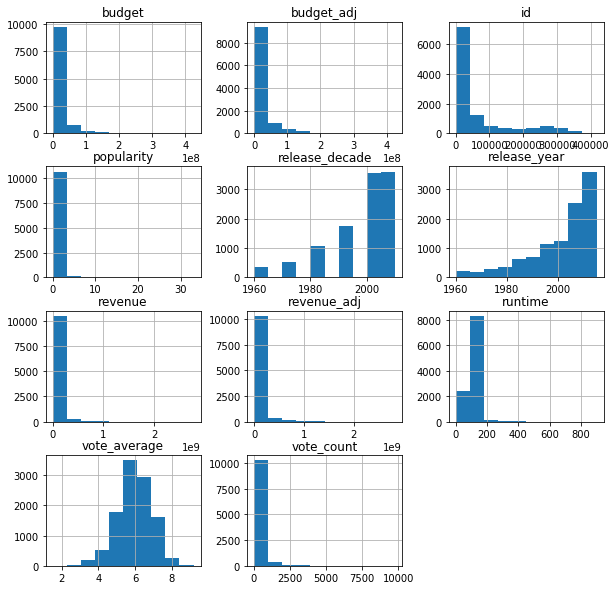

In [72]:
df.hist(figsize=(10,10));

<a id='eda'></a>
## Exploratory Data Analysis

### How many films were released each year?

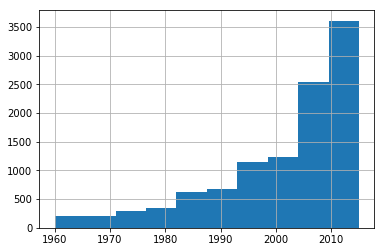

In [73]:
df.release_year.hist();

The number of films released each year has increased steadily since 1960.

### What is the average runtime?

In [74]:
df['runtime'].describe()

count    10866.000000
mean       102.070863
std         31.381405
min          0.000000
25%         90.000000
50%         99.000000
75%        111.000000
max        900.000000
Name: runtime, dtype: float64

The average runtime is 102 minutes. 75% of films are under 111 minutes.

<a id='genre_analysis'></a>
### Genre Analysis

The genres feature contains multiple values separated by the '|' character. Explode the genres feature by creating duplicate rows of each movie for each genre in the genres feature.

**Example**<br>
The genres feature for Jurrassic World contains "Action|Adventure|Science Fiction|Thriller".
This single row would be replaced by four rows - one each for Action, Adventure, Science Fiction, and Thriller:<br>
Jurassic World - Action<br>
Jurassic World - Adventure<br>
Jurassic World - Science Fiction<br>
Jurassic World - Thriller<br>

In [75]:
# Create a custom dataframe with the genres feature exploded using the custom function defined above
genre_df = tidy_split(df, 'genres', sep='|')

#### What is the breakdown of genres overall?

In [76]:
genre_df.groupby('genres').id.count().sort_values(ascending=False)

genres
Drama              4761
Comedy             3793
Thriller           2908
Action             2385
Romance            1712
Horror             1637
Adventure          1471
Crime              1355
Family             1231
Science Fiction    1230
Fantasy             916
Mystery             810
Animation           699
Documentary         520
Music               408
History             334
War                 270
Foreign             188
TV Movie            167
Western             165
Name: id, dtype: int64

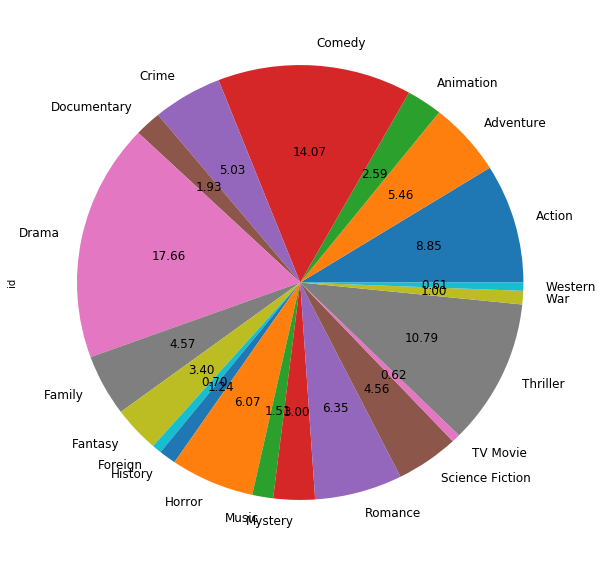

In [77]:
genre_df.groupby('genres').id.count().plot.pie(autopct='%.2f', figsize=(10,10), fontsize=12);

The most popular genres are Drama, Comedy, Thriller, and Action.

#### Which genres are most popular from year to year?

##### Number of films by genre by year
For each year, what are the top three genres?

In [78]:
genre_df_yr_agg = genre_df.groupby(['release_year', 'genres']).count()
g = genre_df_yr_agg['id'].groupby(level=0, group_keys=False)
top_genres_by_yr = g.nlargest(3)
top_genres_yr_df = top_genres_by_yr.to_frame()
top_genres_yr_df

id
release_year genres        
1960         Drama       13
             Action       8
             Comedy       8
1961         Drama       16
             Comedy      10
             Action       7
1962         Drama       21
             Action       8
             Adventure    7
1963         Comedy      13
             Drama       13
             Thriller    10
1964         Drama       20
             Comedy      16
             Crime       10
1965         Drama       20
             Thriller    11
             Action       9
1966         Comedy      16
             Drama       16
             Action      14
1967         Comedy      17
             Drama       16
             Romance     11
1968         Drama       20
             Comedy       9
             Action       6
1969         Drama       13
             Comedy      12
             Action      10
...                     ...
2006         Drama      197
             Comedy     155
             Thriller   114
2007         Drama      197
             Comedy     151
             Thriller   125
2008         Drama      233
             Comedy     169
             Thriller   127
2009         Drama      224
             Comedy     198
             Thriller   157
2010         Drama      211
             Comedy     169
             Thriller   135
2011         Drama      214
             Comedy     172
             Thriller   146
2012         Drama      232
             Comedy     176
             Thriller   160
2013         Drama      253
             Comedy     175
             Thriller   175
2014         Drama      284
             Comedy     185
             Thriller   179
2015         Drama      260
             Thriller   171
             Comedy     162

[168 rows x 1 columns]

In [79]:
top_genres_by_yr_df = top_genres_yr_df.unstack(level=1, fill_value=0)
top_genres_by_yr_df.columns = top_genres_by_yr_df.columns.droplevel()

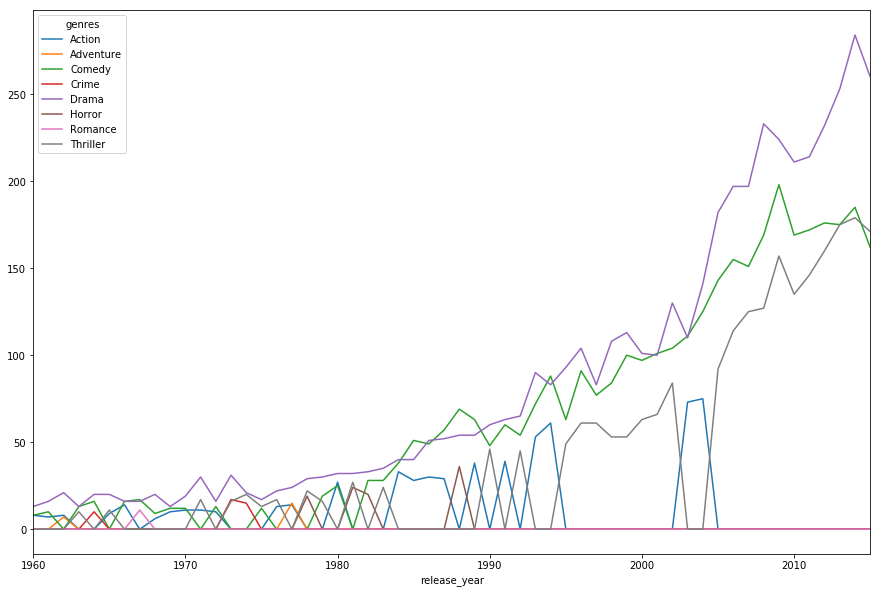

In [80]:
top_genres_by_yr_df.plot(figsize=(15,10));

Drama is consistently in the top three every year.

##### Number of films by genre by decade
There could be wild swings from year to year. Analyze based on decades instead.

For each decade, what are the top three genres?

In [81]:
genre_df_agg = genre_df.groupby(['release_decade', 'genres']).count()
g = genre_df_agg['id'].groupby(level=0, group_keys=False)
top_genres = g.nlargest(3)
top_genres_df = top_genres.to_frame()
top_genres_df

id
release_decade genres        
1960           Drama      168
               Comedy     113
               Action      78
1970           Drama      239
               Thriller   148
               Comedy     122
1980           Comedy     428
               Drama      423
               Action     272
1990           Drama      862
               Comedy     737
               Thriller   495
2000           Drama     1615
               Comedy    1354
               Thriller   975
2010           Drama     1454
               Comedy    1039
               Thriller   966

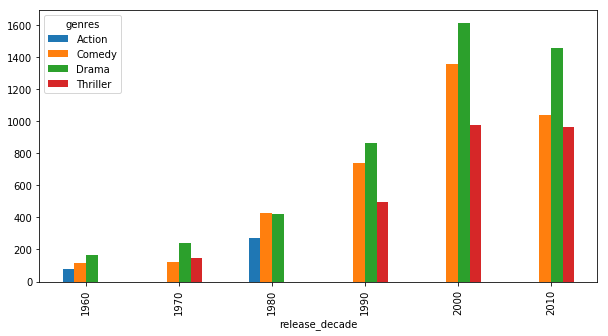

In [82]:
top_genres_by_dec_df = top_genres_df.unstack(level=1, fill_value=0)
top_genres_by_dec_df.columns = top_genres_by_dec_df.columns.droplevel()
top_genres_by_dec_df.plot.bar(figsize=(10,5));

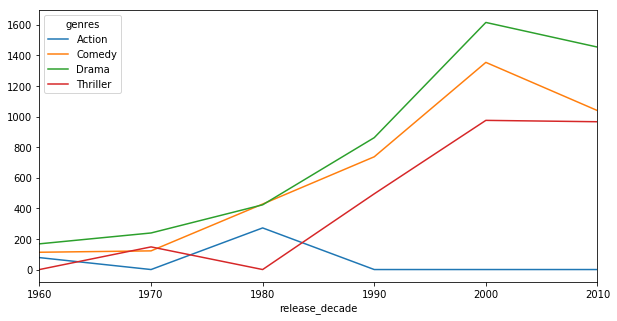

In [83]:
top_genres_by_dec_df.plot(figsize=(10,5));

Comedy and Drama are in the top three every decade with Drama first. The third spot each decade is taken by either Action or Thriller. Thriller has taken third spot for the last three decades.

### Revenue Analysis

The budget_adj and revenue_adj features contain budget and revenue numbers converted to 2010 dollars and should be used for accurate comparison. Some rows contain 0 in the budget_adj and revenue_adj feature. Remove these rows since they are invalid.

In [84]:
# Create a custom dataframe containing only rows whose budget_adj and revenue_adj values are greater than 0
rev_df = df[(df['budget_adj'] > 0) & (df['revenue_adj'] > 0)]

<a id='genre_revenue'></a>
#### What genres earn the highest revenue?

Expand the genres feature of the revenue dataframe

In [85]:
rev_genre_df = tidy_split(rev_df, 'genres', sep='|')

##### What genres have earned the highest average revenue per movie?

In [86]:
rev_genre_df.groupby('genres').revenue_adj.mean().sort_values(ascending=False)

genres
Animation          2.909574e+08
Adventure          2.714075e+08
Fantasy            2.499928e+08
Family             2.437910e+08
Science Fiction    2.017662e+08
Action             1.952089e+08
War                1.558981e+08
Western            1.356748e+08
Music              1.345660e+08
Thriller           1.280653e+08
History            1.216617e+08
Comedy             1.213979e+08
Romance            1.136903e+08
Mystery            1.136210e+08
Crime              1.102273e+08
Drama              1.013213e+08
Horror             8.140655e+07
TV Movie           5.838910e+07
Documentary        2.480617e+07
Foreign            1.273378e+07
Name: revenue_adj, dtype: float64

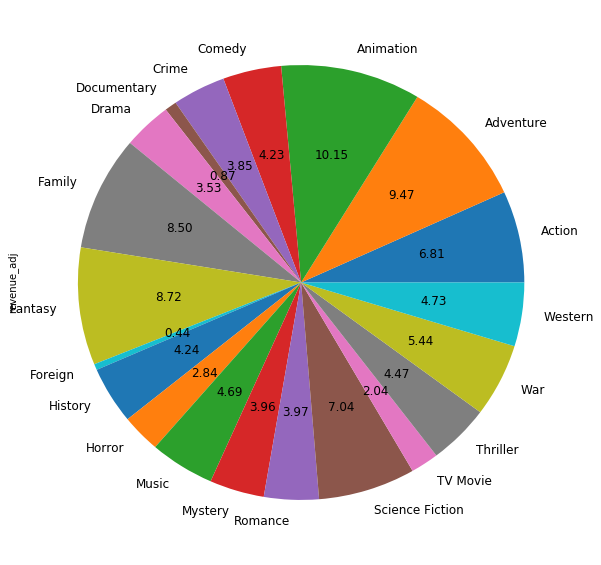

In [87]:
rev_genre_df.groupby('genres').revenue_adj.mean().plot.pie(autopct='%.2f', figsize=(10,10), fontsize=12);

Animation, Adventure, Fantasy, and Family genres earn the highest average revenue per movie.

##### What genres have earned the most total revenue overall?

In [88]:
rev_genre_df.groupby('genres').revenue_adj.sum().sort_values(ascending=False)

genres
Action             211996879523
Adventure          203284193986
Drama              178021553540
Comedy             164736979753
Thriller           154318723552
Science Fiction    104918447659
Family             103611187758
Fantasy             98997129442
Romance             75717735132
Crime               71868199711
Animation           58482433730
Mystery             39085630637
Horror              37691234794
War                 18551875233
Music               18300978092
History             15694362390
Western              7055087880
Documentary           868215791
Foreign               165539106
TV Movie               58389103
Name: revenue_adj, dtype: int64

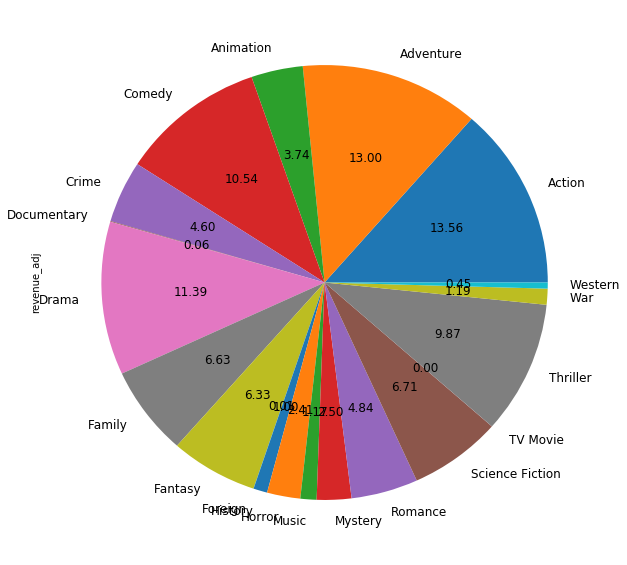

In [89]:
rev_genre_df.groupby('genres').revenue_adj.sum().plot.pie(autopct='%.2f', figsize=(10,10), fontsize=12);

The Action, Adventure, Drama, Comedy, and Thriller genres have earned the most total revenue overall.

<a id='director_revenue'></a>
#### Which directors earn the highest revenue?

In [90]:
rev_direct_df = tidy_split(rev_df, 'director', sep='|')

##### Which directors have earned the highest average revenue per movie?

In [91]:
rev_direct_df_mean = rev_direct_df.groupby('director').agg({'revenue_adj':'mean', 'id':'count'}).rename(columns={'id':'num_films'}).sort_values(by='revenue_adj', ascending=False)
rev_direct_df_mean.head(10)

,revenue_adj,num_films
director,,
Irwin Winkler,1.583050e+09,1
Clyde Geronimi,1.574815e+09,1
Hamilton Luske,1.574815e+09,1
Richard Marquand,1.253819e+09,1
Jennifer Lee,1.192711e+09,1
George Lucas,1.052320e+09,6
David Yates,1.044364e+09,4
James Cameron,9.159026e+08,8
Lee Unkrich,8.540177e+08,4


Exclude the one hit wonders to see which directors earned the highest average revenue per movie over multiple movies

In [92]:
rev_direct_df_multi_film = rev_direct_df_mean[rev_direct_df_mean['num_films'] > 1].head(10)
rev_direct_df_multi_film

,revenue_adj,num_films
director,,
George Lucas,1.052320e+09,6
David Yates,1.044364e+09,4
James Cameron,9.159026e+08,8
Lee Unkrich,8.540177e+08,4
Pierre Coffin,8.387905e+08,3
Pete Docter,7.406167e+08,3
Andrew Adamson,7.298889e+08,4
Wolfgang Reitherman,7.293424e+08,5
Conrad Vernon,7.196849e+08,3


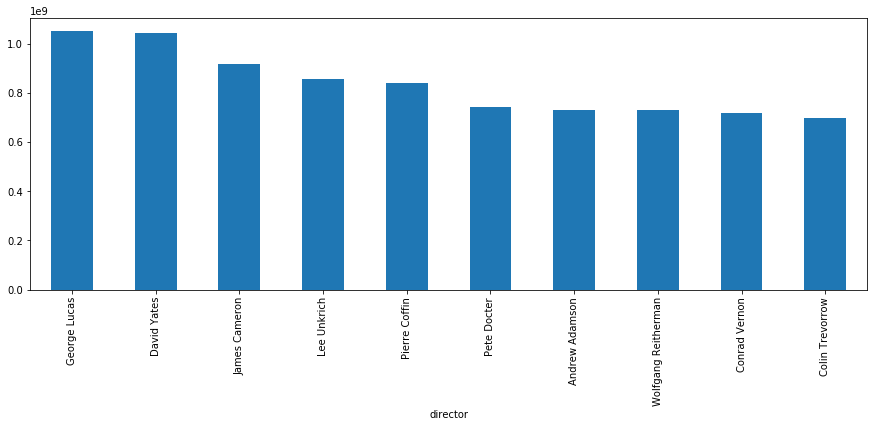

In [93]:
rev_direct_df_multi_film.revenue_adj.plot.bar(figsize=(15,5));

Excluding one hit wonders, George Lucas' films have earned the highest average revenue.

##### Which directors have earned the most total revenue overall?

In [94]:
rev_direct_df_sum = rev_direct_df.groupby('director').agg({'revenue_adj':'sum', 'id':'count'}).rename(columns={'id':'num_films'}).sort_values(by='revenue_adj', ascending=False)
rev_direct_df_sum.head(10)

,revenue_adj,num_films
director,,
Steven Spielberg,15266924022,28
James Cameron,7327220854,8
Peter Jackson,7019847812,11
George Lucas,6313919161,6
Robert Zemeckis,5655648241,15
Michael Bay,5460671953,11
Chris Columbus,4893485764,9
Tim Burton,4660141174,17
David Yates,4177455258,4


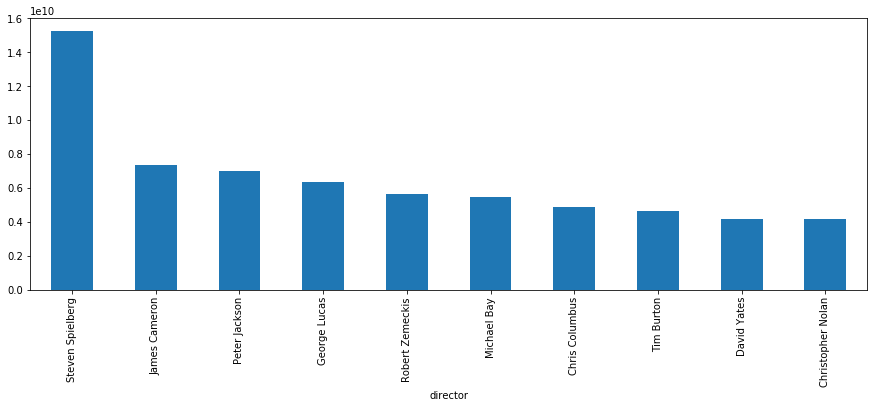

In [95]:
rev_direct_df_sum.head(10).revenue_adj.plot.bar(figsize=(15,5));

Steven Spielberg's films have earned the most total revenue by far.

In [96]:
rev_direct_df_sum.sort_values(by='num_films', ascending=False).head(10)

,revenue_adj,num_films
director,,
Steven Spielberg,15266924022,28
Clint Eastwood,3518207232,24
Ridley Scott,4141847526,21
Woody Allen,1095391838,18
Robert Rodriguez,1287866849,17
Martin Scorsese,2425465785,17
Steven Soderbergh,2475273697,17
Tim Burton,4660141174,17
Robert Zemeckis,5655648241,15


Steven Spielberg has directed the most films during this period (28).

<a id='cast_revenue'></a>
#### Which cast members earn the highest revenue?

In [97]:
rev_cast_df = tidy_split(rev_df, 'cast', sep='|')

##### Which cast members have earned the highest average revenue per movie?

In [98]:
rev_cast_df_mean = rev_cast_df.groupby('cast').agg({'revenue_adj':'mean', 'id':'count'}).rename(columns={'id':'num_films'}).sort_values(by='revenue_adj', ascending=False)
rev_cast_df_mean.head(10)

,revenue_adj,num_films
cast,,
Jason Miller,2.167325e+09,1
Daisy Ridley,1.902723e+09,1
Robert MacNaughton,1.791694e+09,1
Wendy Gazelle,1.583050e+09,1
Ken Howard,1.583050e+09,1
Martha Wentworth,1.574815e+09,1
J. Pat O'Malley,1.574815e+09,1
Ben Wright,1.574815e+09,1
Betty Lou Gerson,1.574815e+09,1


Exclude the one hit wonders to see which cast members earned the highest average revenue per movie over multiple movies

In [99]:
rev_cast_df_multi_film = rev_cast_df_mean[rev_cast_df_mean['num_films'] > 2].head(10)
rev_cast_df_multi_film

,revenue_adj,num_films
cast,,
Mark Hamill,1.475872e+09,5
Carrie Fisher,1.096897e+09,7
Alec Guinness,1.031138e+09,4
Rupert Grint,9.287045e+08,9
Murray Hamilton,8.282192e+08,4
Robert Shaw,8.192120e+08,4
Ian McDiarmid,8.040146e+08,4
Emma Watson,7.325067e+08,12
Richard Armitage,7.226673e+08,4


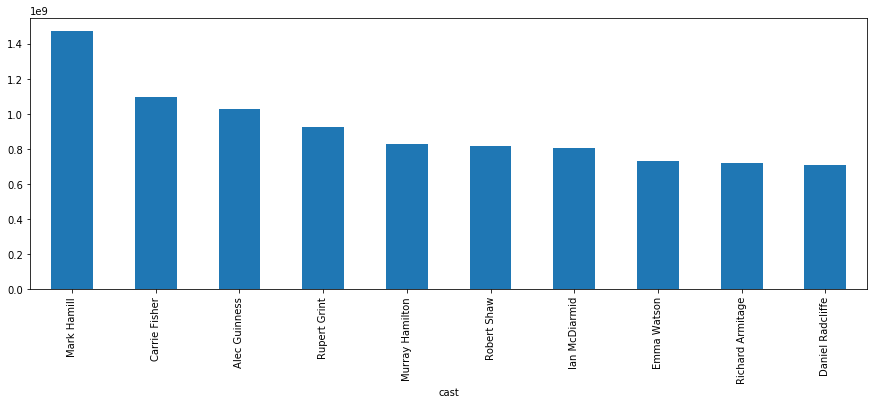

In [100]:
rev_cast_df_multi_film.revenue_adj.plot.bar(figsize=(15,5));

Excluding one hit wonders, Mark Hamill's films have earned the highest average revenue.

In [101]:
top_3_cast = ['Mark Hamill', 'Carrie Fisher', 'Alec Guinness']

rev_cast_df[rev_cast_df['cast'].isin(top_3_cast)][['cast', 'original_title', 'revenue_adj']].sort_values(by='revenue_adj', ascending=False)

,cast,original_title,revenue_adj
1329,Mark Hamill,Star Wars,2789712242
1329,Carrie Fisher,Star Wars,2789712242
1329,Alec Guinness,Star Wars,2789712242
3,Mark Hamill,Star Wars: The Force Awakens,1902723129
3,Carrie Fisher,Star Wars: The Force Awakens,1902723129
7309,Mark Hamill,The Empire Strikes Back,1424626187
7309,Carrie Fisher,The Empire Strikes Back,1424626187
7987,Mark Hamill,Return of the Jedi,1253818981
7987,Carrie Fisher,Return of the Jedi,1253818981
10691,Alec Guinness,Doctor Zhivago,773178594


The top 3 average revenue cast members all appeared in the Star Wars series of films.

##### Which cast members have earned the most total revenue overall?

In [102]:
rev_cast_df_sum = rev_cast_df.groupby('cast').agg({'revenue_adj':'sum', 'id':'count'}).rename(columns={'id':'num_films'}).sort_values(by='revenue_adj', ascending=False)
rev_cast_df_sum.head(10)

,revenue_adj,num_films
cast,,
Harrison Ford,14285696521,34
Tom Cruise,11175071449,33
Tom Hanks,10433513701,34
Emma Watson,8790079991,12
Ian McKellen,8628836944,14
Johnny Depp,8518032607,35
Daniel Radcliffe,8515082231,12
Eddie Murphy,8403306642,32
Rupert Grint,8358340710,9


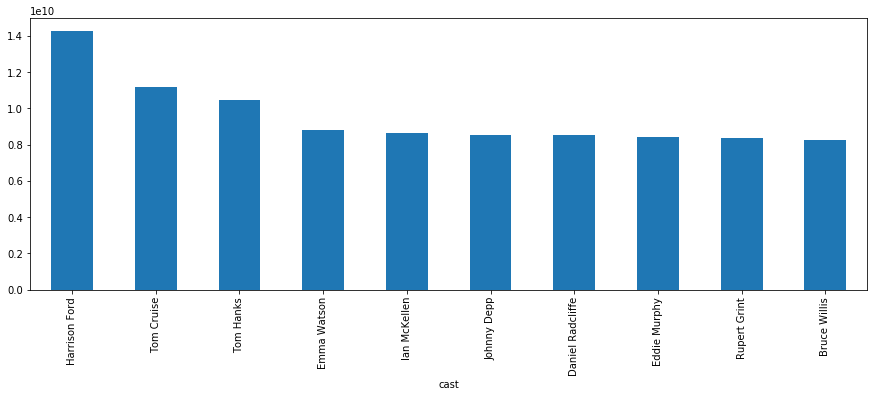

In [103]:
rev_cast_df_sum.head(10).revenue_adj.plot.bar(figsize=(15,5));

Harrison Ford's films have earned the most total revenue.

<a id='conclusions'></a>
## Conclusions

In general, the number of films released has increased over time. The average runtime is 102 minutes with three quarters of all historical films coming in at less than 111 minutes.

Most films released each year are in the Drama and Comedy genres. However, animated films have historically earned the most revenue per film on average with Drama earning close to the least and Comedy in the middle of the pack.

When it comes to the people aspect, George Lucas is the most effective director earning the highest revenue per film on average out of all directors who have directed more than one film. However, Steven Spielberg has earned the most total revenue overall due primarily to the fact that he directed an industry leading 28 films.

Cast wise Mark Hamill's films earned the highest average revenue. In fact, the top three cast members in terms of highest average revenue per film all apeared in the Star Wars series of films. The crown for higest total revenue overall goes to Harrison Ford whose 34 films earned over $14 billion combined.

<a id='caveats'></a>
## Caveats

These data and conclusions do not imply a causitive effect. This notebook explores correlation between different features such as genre, director, and cast and film revenue. However it does not indicate causation. For example, it does not indicate that the specific genres, directors, or cast members _caused_ the high amounts of revenue their films generated. There are many other factors that could be related such as time of year, marketing campaigns, genre trends, target audience, etc.

<a id='references'></a>
## References

* https://stackoverflow.com/questions/36226083/how-to-find-which-columns-contain-any-nan-value-in-pandas-dataframe-python
* https://stackoverflow.com/questions/37366717/pandas-print-column-name-with-missing-values
* https://gist.github.com/ltfschoen/4c5d2cf26b8be5355043273493a6b8b9
* https://stackoverflow.com/questions/23833763/pandas-count-number-of-elements-in-each-column-less-than-x
* https://stackoverflow.com/questions/17097236/how-to-replace-values-with-none-in-pandas-data-frame-in-python
* https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year
* https://stackoverflow.com/questions/40716571/pandas-replace-part-of-a-column-with-another-column
* https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
* https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows
* https://github.com/cognoma/genes/blob/721204091a96e55de6dcad165d6d8265e67e2a48/2.process.py#L61-L95
* https://stackoverflow.com/questions/33240937/keeping-rows-in-pandas-where-the-same-id-appears-more-than-n-times-and-convert-t
* https://stackoverflow.com/questions/32918506/pandas-how-to-filter-for-items-that-occur-more-than-once-in-a-dataframe
* https://stackoverflow.com/questions/25386870/pandas-plotting-with-multi-index
* https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index
* https://stackoverflow.com/questions/38174155/group-dataframe-and-get-sum-and-count